In [44]:
import model as m
import explore as e
import wrangle as w
import pandas as pd
from importlib import reload
from sklearn.linear_model import LinearRegression,TweedieRegressor,LassoLars
import evaluate as ev
import warnings
warnings.simplefilter('ignore')

In [45]:
train,validate,test = w.tvt_split(w.wrangle_zillow())

In [71]:
reload(m)
md, mean_baseline = m.select_baseline(train.log_error)
md

|                 |     SSE |       MSE |     RMSE |
|:----------------|--------:|----------:|---------:|
| Mean Baseline   | 1285.55 | 0.0296687 | 0.172246 |
| Median Baseline | 1289.55 | 0.0297612 | 0.172514 |
### Because mean outperformed median on all metrics,         we will use mean as our baseline

In [47]:
reload(m)
train_process_frame = train[['fireplace_count','latitude','longitude','tax_value','calc_sqft','bed_count','bath_count','log_error']].copy()
features = ['fireplace_count','bed_count','bath_count']
cluster_cols = ['tax_value','calc_sqft','latitude','longitude']
cluster_name = 'cluster_fuck'
target = 'log_error'
# log_error_min = train_process_frame.log_error.min()
# train_process_frame.log_error = train_process_frame.log_error - log_error_min
train_process_frame = train_process_frame.reset_index(drop=True)
clustered_scaled,scaler,clusterer = m.scale_and_cluster(train_process_frame,features=features,target=target,cluster_cols=cluster_cols,cluster_name=cluster_name,k=7)
regressors = m.generate_regressor(clustered_scaled,features=features,target=target,cluster_name=cluster_name,regressor=LinearRegression(normalize=True))
ypred = m.apply_to_clusters(clustered_scaled,features=features,target=target,cluster_name=cluster_name,regressors=regressors)
clustered_scaled.shape, train_process_frame.shape

((43330, 5), (43330, 8))

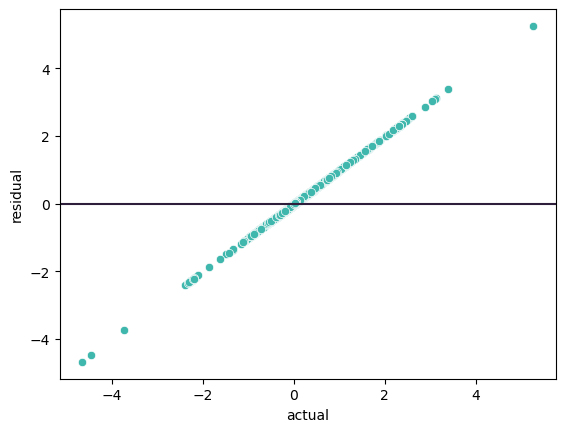

In [48]:
import evaluate as ev
ev.plot_residuals(ypred.y_true,ypred.y_pred)


In [75]:

ev.regression_errors(ypred.y_true,ypred.y_pred,'Regression Model')[['RMSE']]

,RMSE
Regression Model,0.172223


In [62]:
from sklearn.linear_model import TweedieRegressor
reload(m)
reload(ev)
modeling_vars = ['fireplace_count','latitude','longitude','tax_value','calc_sqft','log_error']
training = train[modeling_vars]
validating = validate[modeling_vars]
testing = test[modeling_vars]
features = ['fireplace_count','tax_value','calc_sqft']
cluster_cols = ['tax_value','calc_sqft']
cluster_name = 'tax_and_location'
target = 'log_error'
k = 7
kmeans = None
scaler = None
regressor = TweedieRegressor(power=0,alpha=1.0)
current_df = training
tweedie_train_predictions,scaler,kmeans,regressor = m.process_model(df=current_df,features=features,
    target=target,cluster_cols=cluster_cols,cluster_name=cluster_name,regressor=regressor,k=k,kmeans=kmeans,scaler=scaler)
current_df = validating
tweedie_validate_predictions,_,_,_= m.process_model(df=current_df,features=features,
    target=target,cluster_cols=cluster_cols,cluster_name=cluster_name,regressor=regressor,k=k,kmeans=kmeans,scaler=scaler)
regressor = LassoLars(alpha=1.0)
current_df = training
llars_train_predictions,scaler,kmeans,regressor = m.process_model(df=current_df,features=features,
    target=target,cluster_cols=cluster_cols,cluster_name=cluster_name,regressor=regressor,k=k,kmeans=kmeans,scaler=scaler)
current_df = validating
llars_validate_predictions,_,_,_ = m.process_model(df=current_df,features=features,
    target=target,cluster_cols=cluster_cols,cluster_name=cluster_name,regressor=regressor,k=k,kmeans=kmeans,scaler=scaler)
regressor = LinearRegression(normalize=True)
current_df = training
linreg_train_predictions,scaler,kmeans,regressor = m.process_model(df=current_df,features=features,
    target=target,cluster_cols=cluster_cols,cluster_name=cluster_name,regressor=regressor,k=k,kmeans=kmeans,scaler=scaler)
current_df = validating
linreg_validate_predictions,_,_,_= m.process_model(df=current_df,features=features,
    target=target,cluster_cols=cluster_cols,cluster_name=cluster_name,regressor=regressor,k=k,kmeans=kmeans,scaler=scaler)
ev.get_errors([tweedie_train_predictions,tweedie_validate_predictions,llars_train_predictions,llars_validate_predictions,linreg_train_predictions,linreg_validate_predictions],
['TweedieRegressor train','TweedieRegressor validate','LASSO+LARS train','LASSO+LARS validate','LinearRegression train','LinearRegression validate'])
llars_validate_predictions.min()


y_true   -2.406257
y_pred    0.034631
dtype: float64

In [88]:
reload(m)
reload(ev)
errors = m.train_and_validate_errors(train,validate)
_,mean_eval = m.select_baseline(train.log_error)

pd.concat([mean_eval,errors],axis=0)

,SSE,MSE,RMSE,ESS,TSS
Mean Baseline,1285.545898,0.029669,0.172246,NaN,NaN
TweedieRegressor train,1285.540149,0.029669,0.172246,2.617750e-05,1285.540176
TweedieRegressor validate,521.722318,0.028095,0.167615,1.052695e-02,521.732845
LASSO+LARS train,1285.545898,0.029669,0.172246,1.103633e-27,1285.545898
LASSO+LARS validate,521.725601,0.028095,0.167616,1.113536e-02,521.736736
LinearRegression train,1283.216118,0.029615,0.172090,2.329780e+00,1285.545898
LinearRegression validate,520.973372,0.028055,0.167495,1.056377e+00,522.029749
